In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.linalg import svd
import numpy as np
import matplotlib.patches as mpatches

In [18]:
# Load the dataset
file_path = "./European_data_2000.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Convert columns to appropriate data types
df["releaseYear"] = df["releaseYear"].astype("Int64")
df["runtimeMinutes"] = df["runtimeMinutes"].astype("Int64")
df["numberOfVotes"] = df["numberOfVotes"].astype("Int64")

print(df)

        titleId                                imdbUrl  \
0     tt3042384  https://www.imdb.com/title/tt3042384/   
1     tt2486278  https://www.imdb.com/title/tt2486278/   
2     tt1361313  https://www.imdb.com/title/tt1361313/   
3     tt0222124  https://www.imdb.com/title/tt0222124/   
4     tt0421229  https://www.imdb.com/title/tt0421229/   
...         ...                                    ...   
1995  tt0003930  https://www.imdb.com/title/tt0003930/   
1996  tt1638002  https://www.imdb.com/title/tt1638002/   
1997  tt0081738  https://www.imdb.com/title/tt0081738/   
1998  tt0033627  https://www.imdb.com/title/tt0033627/   
1999  tt0063135  https://www.imdb.com/title/tt0063135/   

                                          originalTitle titleType  \
0                                                   Ida     movie   
1                                            Blood Shed     movie   
2                                         The Extra Man     movie   
3     Se tutte le donne del

In [19]:
print(df.columns.tolist())

['titleId', 'imdbUrl', 'originalTitle', 'titleType', 'releaseYear', 'runtimeMinutes', 'isAdult', 'imdbRating', 'numberOfVotes', 'allCountries', 'mainCountry', 'allLanguages', 'firstLanguage', 'englishTitle', 'topFiveActors', 'directors', 'writers', 'plotShort', 'plotMedium', 'plotLong', 'genres', 'keywords', 'production']


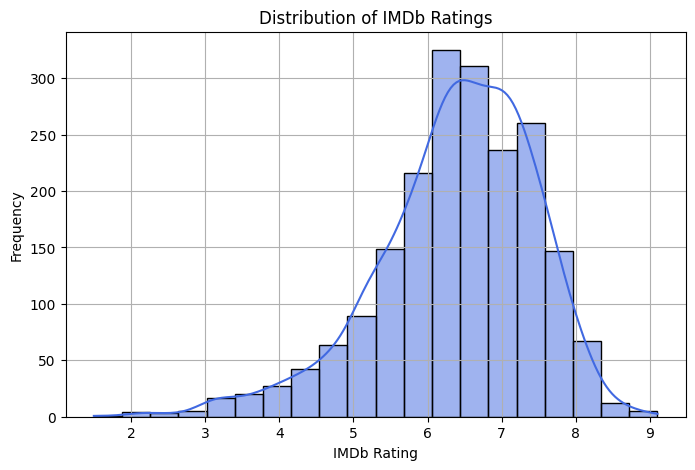

In [20]:
# Visualization: Distribution of IMDb Ratings
plt.figure(figsize=(8, 5))
sns.histplot(df["imdbRating"], bins=20, kde=True, color="royalblue")
plt.title("Distribution of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.ylabel("Frequency")
plt.grid()
plt.show()

C:\Users\gisle\AppData\Local\Temp\ipykernel_55068\3396268489.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")


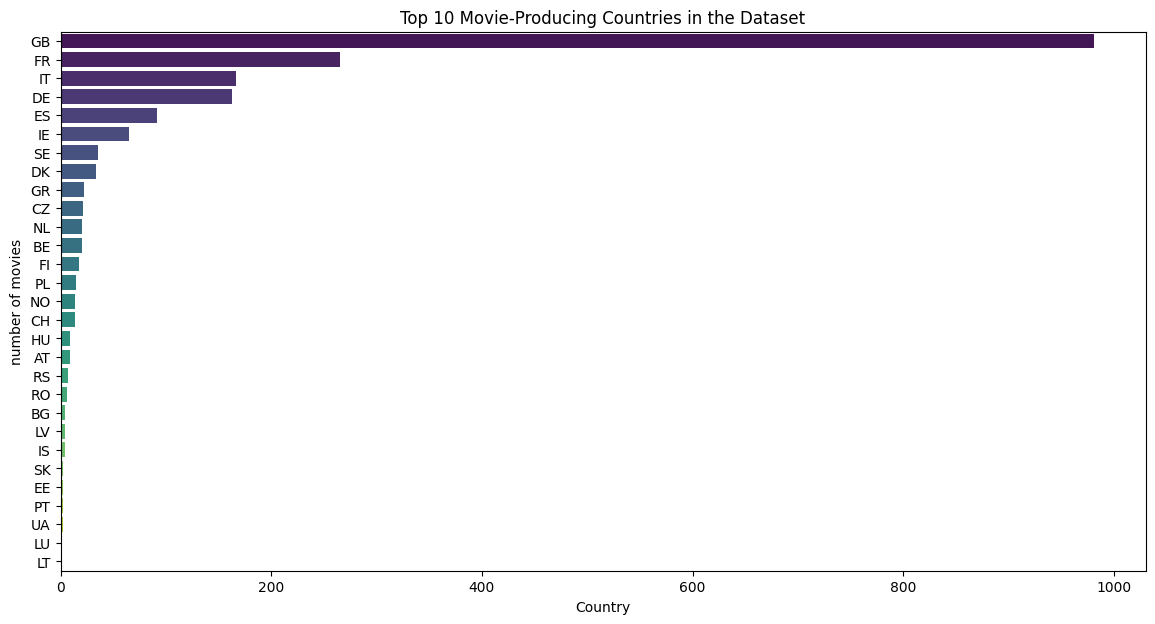

In [21]:
# Visualization: Movie count by country
plt.figure(figsize=(14, 7))
top_countries = df["mainCountry"].value_counts().nlargest(29)
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")
plt.xlabel("Country")
plt.ylabel("number of movies")
plt.title("Top 10 Movie-Producing Countries in the Dataset")
plt.show()

C:\Users\gisle\AppData\Local\Temp\ipykernel_55068\1833505293.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette="coolwarm")


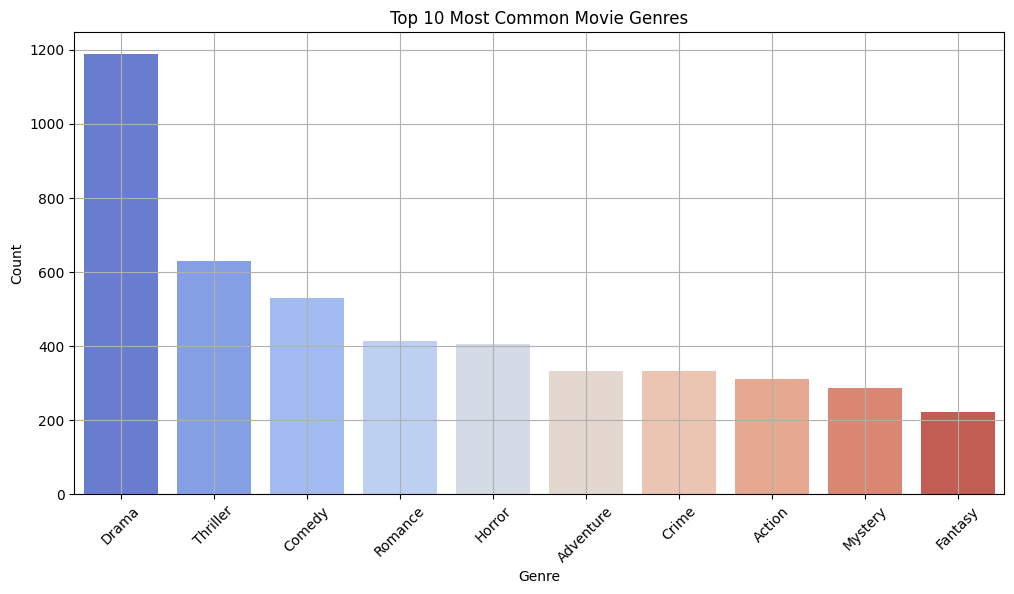

In [22]:
plt.figure(figsize=(12, 6))
all_genres = df["genres"].str.split(", ").explode()
top_genres = all_genres.value_counts().nlargest(10)
sns.barplot(x=top_genres.index, y=top_genres.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Top 10 Most Common Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.grid()
plt.show()

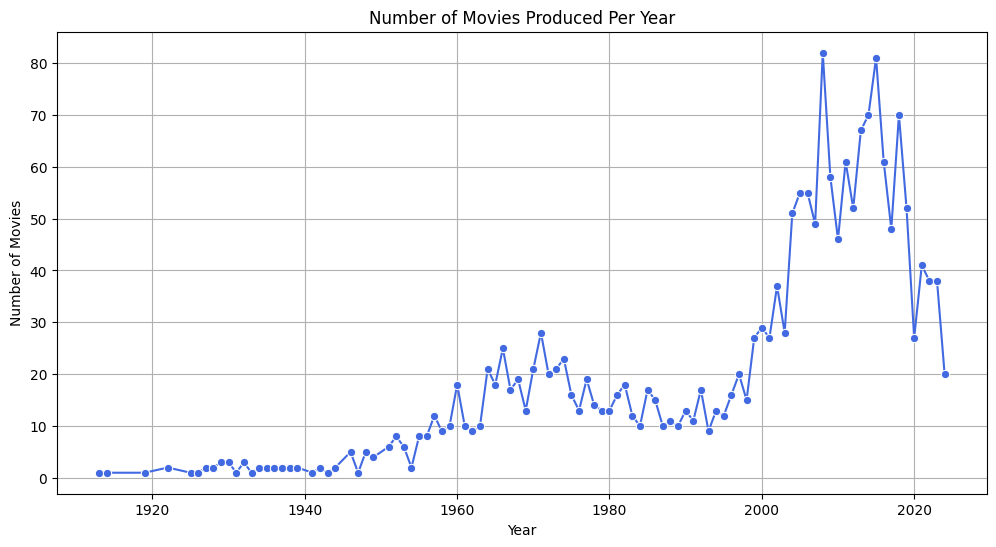

In [23]:
plt.figure(figsize=(12, 6))
movies_per_year = df["releaseYear"].value_counts().sort_index()
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, marker="o", color="royalblue")
plt.title("Number of Movies Produced Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.grid()
plt.show()

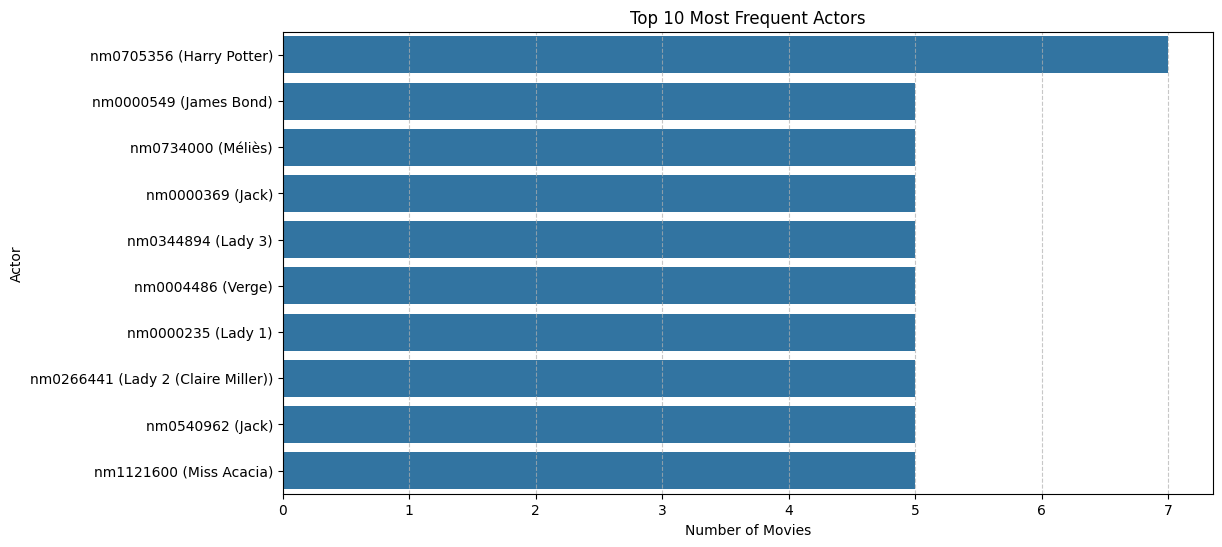

In [24]:
plt.figure(figsize=(12, 6))
all_actors = df["topFiveActors"].str.split(", ").explode()
top_actors = all_actors.value_counts().nlargest(10)
sns.barplot(x=top_actors.values, y=top_actors.index)
plt.title("Top 10 Most Frequent Actors")
plt.xlabel("Number of Movies")
plt.ylabel("Actor")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

### Possibilities for network data analysis
actors and writers/directors and see hidden patterns (create a network where the vertices are the people and the edges the movies or a bipartite network with actors on one side and directors on the other)
countries and genre mapped (create a map of the world and when you hover over the country genres will pop up)
runtime and the rating if it goes up or down 


In [25]:
df_copy = df.copy()

# Select only the relevant columns
df_cleaned = df_copy[["releaseYear", "runtimeMinutes", "isAdult", "imdbRating", "numberOfVotes"]]

# Convert categorical/binary columns
df_cleaned["isAdult"] = df_cleaned["isAdult"].astype(int)  # Ensure it's binary (0/1)

# Check to see if there are any missing values
print(df_cleaned.isnull().sum())

# We'll keep the dropping of null values just in case
df_cleaned = df_cleaned.dropna()

releaseYear       0
runtimeMinutes    0
isAdult           0
imdbRating        0
numberOfVotes     0
dtype: int64


C:\Users\gisle\AppData\Local\Temp\ipykernel_55068\303158350.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["isAdult"] = df_cleaned["isAdult"].astype(int)  # Ensure it's binary (0/1)


In [26]:
# The attributes above are of interest when it comes to the target variable being survivability and we can see that we have no more 
# missing attributes that are not numerical.

# One last thing before we apply PCA, we need to standardize the data. This is because PCA is sensitive to the scale of the data.
# One reason is that if we compare age to fare, age can vary from 0 to 100, whilst fare can vary from 0 to 1000. This means that
# the variance in the data is dominated by fare. We need to standardize the data so that the variance in the data is not dominated
# by one attribute. We can do this by subtracting the mean and dividing by the standard deviation of each attribute! 

# Standardize the data using the StandardScaler import, mathematically this is fairly simple, as it involves Z scoring the data
# with Z = (X - myu) / sigma. This forms the basis of a normal distribution.
scaler = StandardScaler()
# fit calculates the mean and standard deviation of each attribute and transform applies the Z score formula to each attribute.
df_standardized = scaler.fit_transform(df_cleaned)

# Let's see how it looks like now:
print(df_standardized)

[[ 0.71057426 -1.09082732 -0.03875891  0.94787563  0.05707806]
 [ 0.71057426 -0.26016753 -0.03875891 -3.07330157 -0.41399471]
 [ 0.57290609  0.17959353 -0.03875891 -0.54837635 -0.37676828]
 ...
 [-0.80377561 -0.99310264 -0.03875891 -0.26782911 -0.36197426]
 [-2.59346183  0.91252864 -0.03875891  0.85435988 -0.35743483]
 [-1.35444829 -0.40675455 -0.03875891 -1.48353384 -0.39368797]]


In [27]:
# All the values above show how many standard deviations away from the mean the data is. Notice how there's one value that is 4.94
# standard deviations away from the mean. This is an outlier that we should take into account when we do PCA.

# Another thing to note is that by standardizing the data, we don't need to do
# Y = df_standardized - np.mean(df_standardized, axis=0) anymore because standardizing already transforms the attribute so that the mean is 0.

# Let's finally perform PCA via Single Value Decomposition svd:
U, S, Vt = svd(df_standardized, full_matrices=False)

# Compute variance, squared of each sigma s explained by principal components
# For example: if S is [3, 2, 1] then S * S is [9, 4, 1] and (S * S).sum() is 9 + 4 + 1 = 14.
# rho is [9/14, 4/14, 1/14] = [0.64, 0.29, 0.07] where we get the variance explained by each principal component!
rho = (S * S) / (S * S).sum()

# Let's see how much variance is explained by the first 3 principal components:
print("The first principal component explains", rho[0] * 100, "% of the variance.")
print("The second principal component explains", rho[1] * 100, "% of the variance.")
print("The third principal component explains", rho[2] * 100, "% of the variance.")

The first principal component explains 32.88256189967554 % of the variance.
The second principal component explains 21.488910689683664 % of the variance.
The third principal component explains 19.89747056627522 % of the variance.


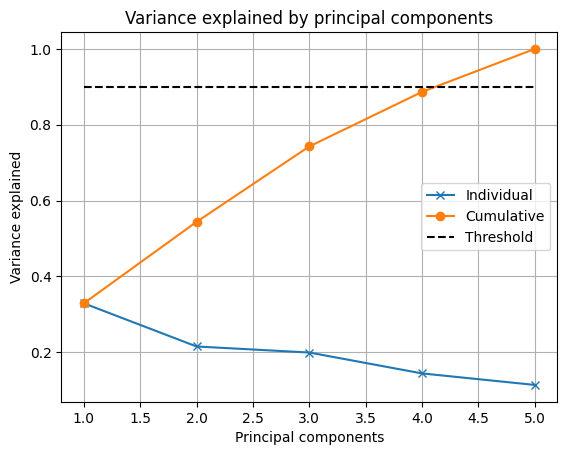

In [28]:
# We can see that the first three principle components are ordered from highest to lowest variance explained.
# Usually we want to define a threshold, which in our case will be 90% of the variance explained.

threshold = 0.9

# Let's try to visualize this better via plots:
plt.figure()
# First plot shows the variance explained by each principal component
plt.plot(range(1, len(rho) + 1), rho, "x-")
# Second will show the cumulative variance explained by the principal components
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
# Let's now add the threshold
plt.plot([1, len(rho)], [threshold, threshold], "k--")
# Add a title
plt.title("Variance explained by principal components")
# Label the axis
plt.xlabel("Principal components")
plt.ylabel("Variance explained")
# Add legend and grid as visual aid
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()

Principal directions 1 - 5:


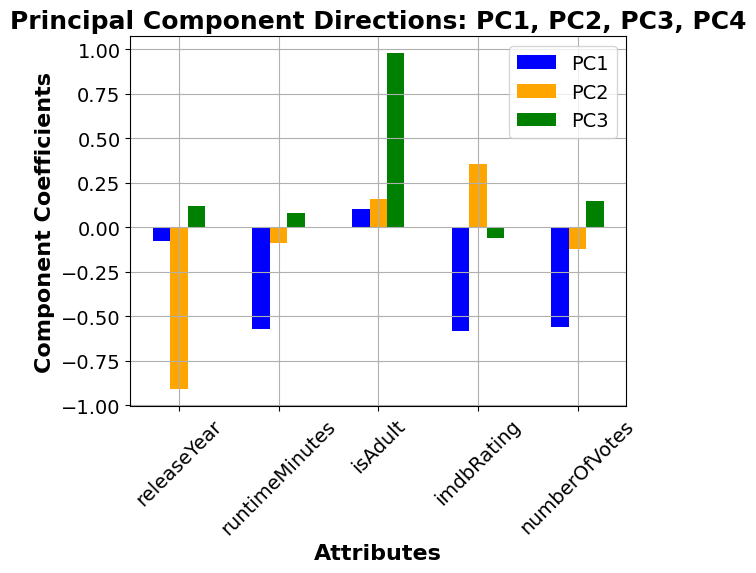

In [29]:
# Remeber earlier, we performed the svd U, S, Vt = svd(df_standardized, full_matrices=False)
# Now we extract the Vt, which is a matrix that contains the vectors defining the principle directions.
principal_directions = Vt.T

# Begin by printing how to principle directions look like
print("Principal directions 1 - 5:")

# Convert the principal directions to a DataFrame for better formatting
principal_directions_df = pd.DataFrame(principal_directions)

# Transpose the DataFrame to show each principal direction as a column
principal_directions_df = principal_directions_df.T

# Set the components to plot in each subplot
pcs_top = [0, 1, 2]  # First three principal components
pcs_bottom = [3, 4]  # Last two principle components

# Start by configuring the plot
legendStrs_top = ["PC" + str(e + 1) for e in pcs_top]
legendStrs_bottom = ["PC" + str(e + 1) for e in pcs_bottom]
colors_top = ["b", "orange", "g",]
colors_bottom = ["b", "orange",]
bar_width = 0.175
# Below simply creates an array from 0 to the number of principal directions
r = np.arange(principal_directions.shape[0])

# First Subplot: PC1, PC2, PC3, PC4
for i, pc in enumerate(pcs_top):
    # r + i * bar_width calculates the positions of the bars on the x_axis and we plot on the y axis the principal directions of each vector
    plt.bar(r + i * bar_width, principal_directions[:, pc], width=bar_width, color=colors_top[i], label=legendStrs_top[i])
    
# Config the plots more with labels and titles
plt.xticks(r + bar_width, df_cleaned.columns, rotation=45, fontsize=14) 
plt.yticks(fontsize=14)  
plt.xlabel("Attributes", fontsize=16, fontweight='bold')  
plt.ylabel("Component Coefficients", fontsize=16, fontweight='bold') 
plt.title("Principal Component Directions: PC1, PC2, PC3, PC4", fontsize=18, fontweight='bold')
plt.legend(fontsize=14)
plt.grid(True)

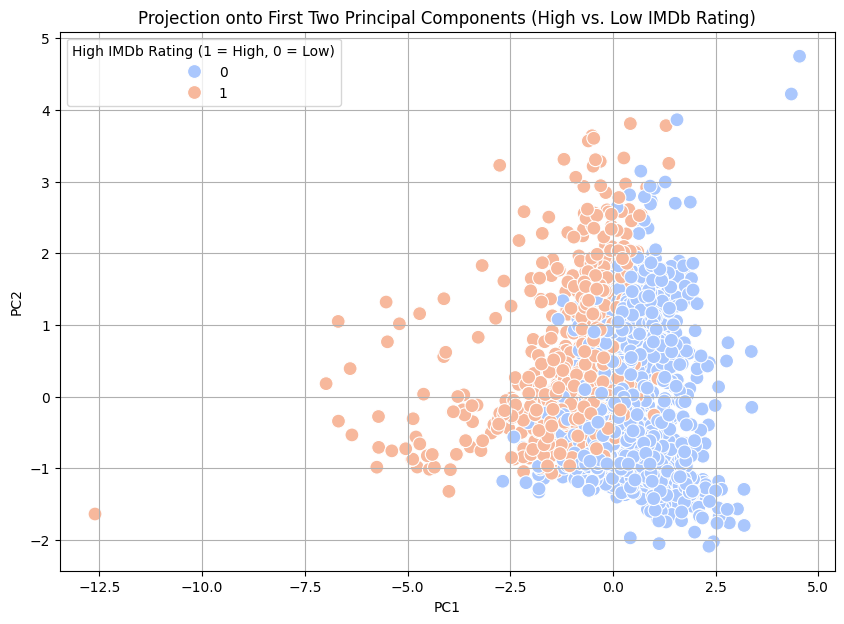

In [ ]:
# Project the data onto the principal components
scores = U * S  # Principal component scores

# Convert to DataFrame
projected_df = pd.DataFrame(scores, columns=[f'PC{i+1}' for i in range(scores.shape[1])])

# Define the target variable: high or low IMDb rating
df_cleaned["high_rating"] = (df_cleaned["imdbRating"] >= 7).astype(int)  # 1 = high rating, 0 = low rating

# Add target variable to projected data
projected_df["high_rating"] = df_cleaned["high_rating"].values

# Visualize PC1 vs. PC2
plt.figure(figsize=(10, 7))
sns.scatterplot(x=projected_df['PC1'], y=projected_df['PC2'], hue=projected_df["high_rating"], palette='coolwarm', s=100)
plt.title('Projection onto First Two Principal Components (High (Greater than 7 / 10) vs. Low (Less than 7 / 10) IMDb Rating)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="High IMDb Rating (1 = High, 0 = Low)")
plt.grid(True)
plt.show()

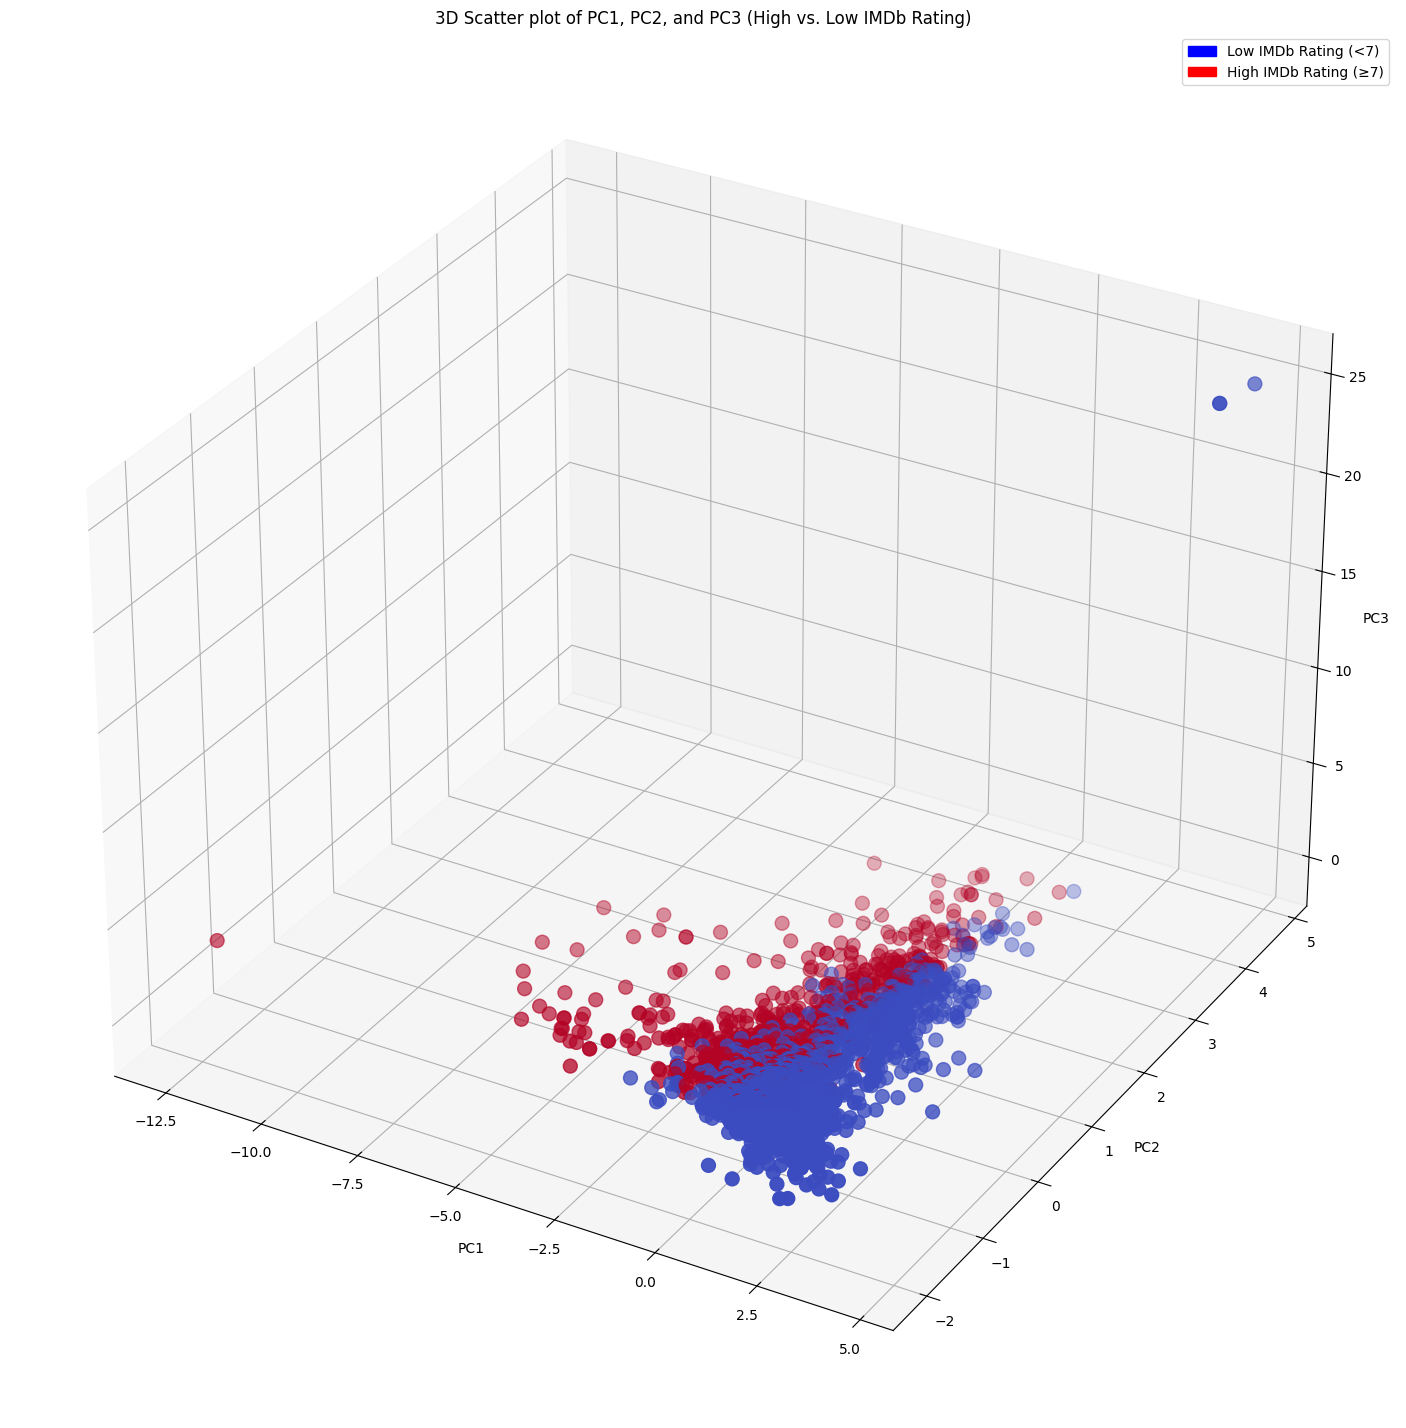

In [32]:
# Create a new figure with interactive 3D projection
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

# 3D Scatter plot of the first three principal components
scatter = ax.scatter(projected_df['PC1'], projected_df['PC2'], projected_df['PC3'], 
                     c=projected_df['high_rating'], cmap='coolwarm', s=100)

# Set axis labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Set the title of the plot
ax.set_title('3D Scatter plot of PC1, PC2, and PC3 (High vs. Low IMDb Rating)')

# Create custom legend
high_rating_patch = mpatches.Patch(color='red', label='High IMDb Rating (≥7)')
low_rating_patch = mpatches.Patch(color='blue', label='Low IMDb Rating (<7)')

# Add legend to the plot (top right corner)
plt.legend(handles=[low_rating_patch, high_rating_patch], loc='upper right')

# Show the plot
plt.show()